# Titanic starter examples: Blending algorithms and feature selection
by Artyom Glazunov

Hello! I'm Artyom, and this is my series of notebooks "Titanic examples", where I show you different ML approaches and algorithms in action on the Titanic task. To remind you, in this task we need to predict the passenger's survival using some information, such as gender, age, class etc.

In this notebook you can check out how to solve the task via blending multiple algorithms results with different weights. You will also see one good approach of feature selection in action - forward selection.

Lets's describe our plan:

- Feature engineering
- Different algorithms preparation
- Feature selection
- Voting classifier
- Submission

#### Let's load libs

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import warnings
import copy
import string
from multiprocessing import Pool

from sklearn.base import TransformerMixin, BaseEstimator, ClassifierMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn import preprocessing
import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer

import optuna

#### Load the data

#### Data Dictionary
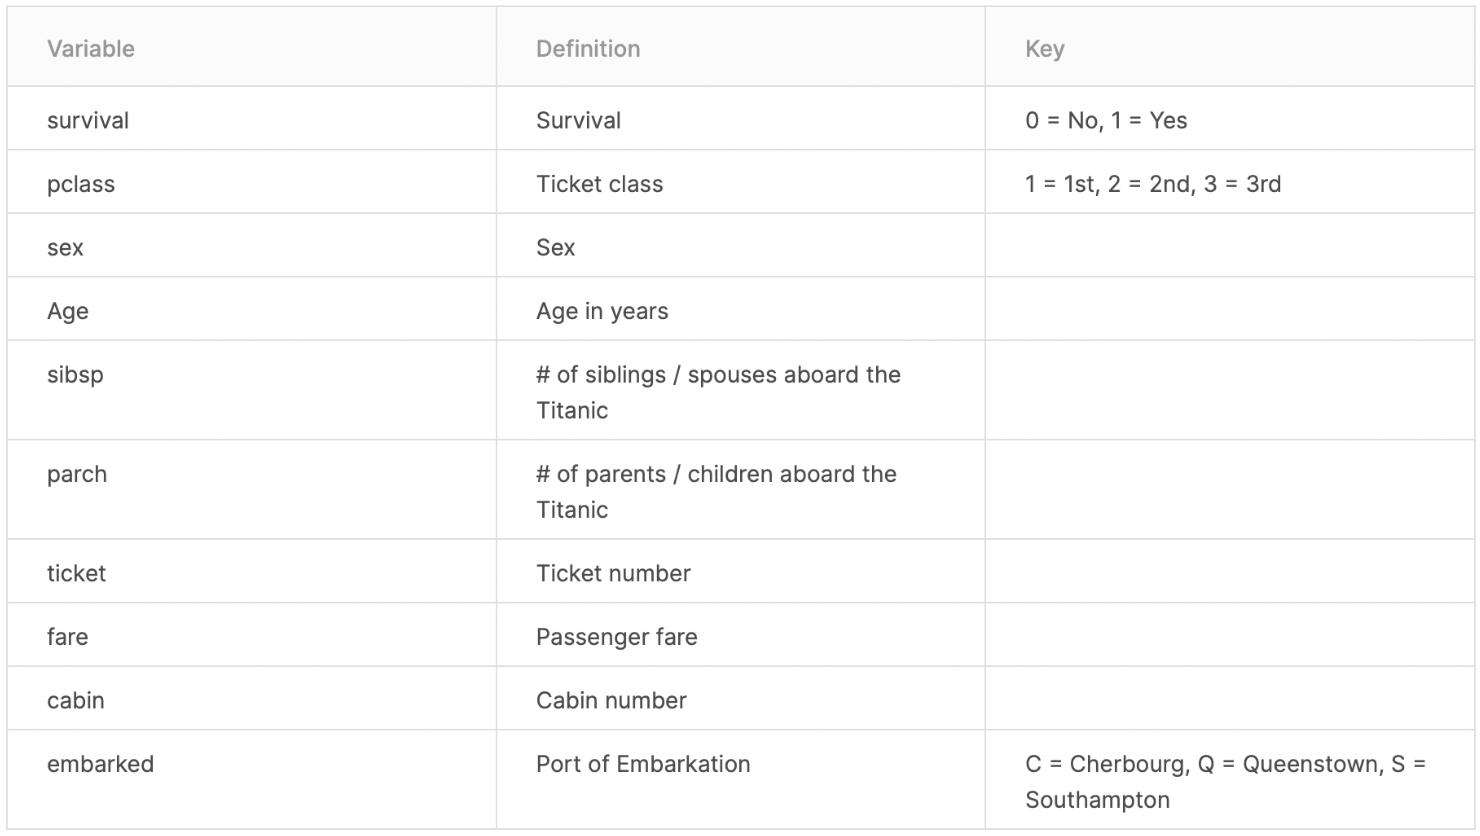

In [3]:
PATH_TO_DATA = '/kaggle/input/titanic'

In [4]:
train_data = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'))
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data = pd.read_csv(os.path.join(PATH_TO_DATA, 'test.csv'))
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_data.shape, test_data.shape

((891, 12), (418, 11))

#### Let's remove some useless symbols

In [7]:
def remove_digits_and_other(x):
    #Clean up feature values from digits and other symbols
    
    return ''.join(i for i in str(x) if not i.isdigit() and i not in ["/", ".", " "])

remove_digits_and_other('B69')

'B'

In [8]:
train_data["Cabin_class"] = train_data["Cabin"].apply(remove_digits_and_other)
train_data["Ticket_kind"] = train_data["Ticket"].apply(remove_digits_and_other)

#### Next, we'll create some new features using info about passengers.

In [9]:
def create_super_features(data_in, feature_names=["super_bin", "super_cat"], q20age=19, med=28, q80age=41):
    #Create additional features using default set
    
    data = data_in.copy()
    
    super_bin = []
    super_cat = []
    
    for ind in range(data.shape[0]):
        human = data.iloc[ind]
        if human["Age"] > med and human["Sex"] == "female" and human["Pclass"] in [1, 2]:
            super_bin.append(1)
        else:
            super_bin.append(0)
            
        if human["Age"] <= q20age and human["Sex"] == "male" and human["Pclass"] == 3:
            super_cat.append("young_poor_male")
        elif human["Age"] > q20age  and human["Age"] <= q80age and human["Sex"] == "male" and human["Pclass"] == 3:
            super_cat.append("middle_poor_male")
        elif human["Age"] > q80age and human["Sex"] == "male" and human["Pclass"] == 3:
            super_cat.append("old_poor_male")
            
        elif human["Age"] <= q20age and human["Sex"] == "female" and human["Pclass"] == 3:
            super_cat.append("young_poor_female")
        elif human["Age"] > q20age  and human["Age"] <= q80age and human["Sex"] == "female" and human["Pclass"] == 3:
            super_cat.append("middle_poor_female")
        elif human["Age"] > q80age and human["Sex"] == "female" and human["Pclass"] == 3:
            super_cat.append("old_poor_female")
        
        elif human["Age"] <= q20age and human["Sex"] == "male" and human["Pclass"] == 2:
            super_cat.append("young_not_rich_male")
        elif human["Age"] > q20age  and human["Age"] <= q80age and human["Sex"] == "male" and human["Pclass"] == 2:
            super_cat.append("middle_not_rich_male")
        elif human["Age"] > q80age and human["Sex"] == "male" and human["Pclass"] == 2:
            super_cat.append("old_not_rich_male")
            
        elif human["Age"] <= q20age and human["Sex"] == "female" and human["Pclass"] == 2:
            super_cat.append("young_not_rich_female")
        elif human["Age"] > q20age  and human["Age"] <= q80age and human["Sex"] == "female" and human["Pclass"] == 2:
            super_cat.append("middle_not_rich_female")
        elif human["Age"] > q80age and human["Sex"] == "female" and human["Pclass"] == 2:
            super_cat.append("old_not_rich_female")
        
        elif human["Age"] <= q20age and human["Sex"] == "male" and human["Pclass"] == 1:
            super_cat.append("young_rich_male")
        elif human["Age"] > q20age  and human["Age"] <= q80age and human["Sex"] == "male" and human["Pclass"] == 1:
            super_cat.append("middle_rich_male")
        elif human["Age"] > q80age and human["Sex"] == "male" and human["Pclass"] == 1:
            super_cat.append("old_rich_male")
            
        elif human["Age"] <= q20age and human["Sex"] == "female" and human["Pclass"] == 1:
            super_cat.append("young_rich_female")
        elif human["Age"] > q20age  and human["Age"] <= q80age and human["Sex"] == "female" and human["Pclass"] == 1:
            super_cat.append("middle_rich_female")
        elif human["Age"] > q80age and human["Sex"] == "female" and human["Pclass"] == 1:
            super_cat.append("old_rich_female")
        
        else:
            super_cat.append("other")
    
    data["super_bin"] = super_bin
    data["super_cat"] = super_cat
    #Let's add interesting numeric features
    data['super_num_fa'] = data['Fare'].values * data["Age"].values
    data["super_num_fare_bin"] = data['Fare'].values * super_bin
    return data

In [10]:
train_data = create_super_features(train_data)

In [11]:
def extract_surname(data):  
    #Thanks to
    #https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

In [12]:
train_data['Family'] = extract_surname(train_data['Name'])

In [13]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_class,Ticket_kind,super_bin,super_cat,super_num_fa,super_num_fare_bin,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,nan,A,0,middle_poor_male,159.5000,0.0000,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,PC,1,middle_rich_female,2708.7654,71.2833,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,nan,STONO,0,middle_poor_female,206.0500,0.0000,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,,1,middle_rich_female,1858.5000,53.1000,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,nan,,0,middle_poor_male,281.7500,0.0000,Allen


#### Let's prepare new features for the test data

In [14]:
test_data["Cabin_class"] = test_data["Cabin"].apply(remove_digits_and_other)
test_data["Ticket_kind"] = test_data["Ticket"].apply(remove_digits_and_other)
test_data = create_super_features(test_data)
test_data['Family'] = extract_surname(test_data['Name'])

#### Create some useful functions and classes

In [15]:
def to_categorical_v2(X, cat_cols = []):
    """Make categorical columns of type "str"
    
    X - initial Pandas DataFrame
    cat_cols - columns for categorization
    """
    
    X_new = X.copy()
    for col in cat_cols:
        X_new[col] = X_new[col].astype(str)
    return X_new


class ColumnExtractor(TransformerMixin, BaseEstimator):
    """Extract some columns from a Pandas DataFrame
    
    columns - the columns of the initial dataset to extract
    """
    
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, data):
        #data - initial pandas DataFrame
        
        return data[self.columns].copy()
    

class ColumnCategorizer(TransformerMixin, BaseEstimator):
    """Creates new categorical features using continuous columns
    
    Requires 
    - quantiles list
    - columns to transform
    - new columns names
    """
    
    def __init__(self, qs, new_columns, old_columns):
        self.qs = qs #quantile list
        self.new_columns = new_columns #columns to create
        self.old_columns = old_columns #initial continuous columns
        self.transformers = {} #transformers storage
        
    def fit(self, X, y=None):
        #Fit transformers on a part of the columns
        
        for column in self.old_columns:
            bins = [X[column].quantile(q=q) for q in self.qs]
            labels = [f"{column}_bin_{l_edge}_{r_edge}" for (l_edge, r_edge) in zip(bins[:-1], bins[1:])]
            self.transformers[column] = preprocessing.FunctionTransformer(
                                             pd.cut, kw_args={'bins': bins, 
                                                              'include_lowest': True,
                                                              'labels': labels, 
                                                              'retbins': False}
                                                         ) 
            self.transformers[column].fit(X[column])
        return self
    
    def transform(self, X):
        #Transform data and return Pandas DataFrame
        
        data_new = X.copy()
        for column_old, column_new in zip(self.old_columns, self.new_columns):
            data_new[column_new] = self.transformers[column_old].transform(data_new[column_old])
        return data_new

    
class DataTransformer(TransformerMixin, BaseEstimator):
    """Transformer wrapper to work with Pandas DataFrames
    
    Class that wraps sklearn transformers (like PowerTransformer)
    and make it transform part of columns returning Pandas DataFrame
    """
    
    def __init__(self, transformer, columns):
        self.transformer = transformer #sklearn transformer
        self.columns = columns #columns to transform
    
    def fit(self, X, y=None):
        #Fit initial transformer on a part of the columns
        self.transformer.fit(X[self.columns])
        return self
    
    def transform(self, X):
        #Transform data and return Pandas DataFrame
        
        data_new = X.copy()
        names = self.columns
        transformed_columns = self.transformer.transform(data_new[names])
        transformed_cols_df = pd.DataFrame(transformed_columns, columns=names)
        for name in names:
            data_new[name] = transformed_cols_df[name].values
        return data_new


class MySimpleClfPipeV3(ClassifierMixin, BaseEstimator):
    """Simple class to create clf pipeline. 
    
    In V3 added a columns extractor, and the class inherits from ClassifierMixin (for the voting).
    
    extractor - select some columns and extract them
    categorizer - create categorical features from continuous columns
    encoder - categorical data encoder
    encoder_second - the second encoder if needed
    encoder_third - the third encoder if needed
    imputer - fill na values
    normalizer - change numeric data distribution
    estimator - classifier
    """
    
    def __init__(self, extractor=None, categorizer=None, 
                 encoder=None, encoder_second=None, encoder_third=None,
                 imputer=None, normalizer=None, 
                 estimator=None):
        self.extractor = extractor
        self.categorizer = categorizer
        self.encoder = encoder
        self.encoder_second = encoder_second
        self.encoder_third = encoder_third
        self.imputer = imputer
        self.normalizer = normalizer
        self.estimator = estimator
        
        
    def fit(self, X, y):
        # fit all the transformers and estimator
        
        data = X.copy()
        if self.extractor:
            data = self.extractor.transform(data)
        if self.categorizer:
            self.categorizer.fit(data)
            data = self.categorizer.transform(data)
        if self.encoder:
            self.encoder.fit(data, y)
            data = self.encoder.transform(data)
        if self.encoder_second:
            self.encoder_second.fit(data, y)
            data = self.encoder_second.transform(data) 
        if self.encoder_third:
            self.encoder_third.fit(data, y)
            data = self.encoder_third.transform(data)    
        if self.imputer:
            self.imputer.fit(data)
            data = self.imputer.transform(data)
        if self.normalizer:
            self.normalizer.fit(data)
            data = self.normalizer.transform(data)
        self.estimator.fit(data, y)
        return self
    
    def transform(self, X):
        # apply transformers to the data 
        
        data = X.copy()
        if self.extractor:
            data = self.extractor.transform(data)
        if self.categorizer:
            data = self.categorizer.transform(data)
        if self.encoder:
            data = self.encoder.transform(data)
        if self.encoder_second:
            data = self.encoder_second.transform(data)
        if self.encoder_third:
            data = self.encoder_third.transform(data)
        if self.imputer:
            data = self.imputer.transform(data)
        if self.normalizer:
            data = self.normalizer.transform(data)       
        return data
    
    def predict(self, X):
        #transform the data and predict labels
        
        data = self.transform(X)
        predictions = self.estimator.predict(data)
        return predictions
    
    def predict_proba(self, X):
        #transform the data and predict probs for classes
        
        data = self.transform(X)
        probs = self.estimator.predict_proba(data)
        return probs

#### Let's initialize different pipelines. In this part we will use the results from the previous notebooks.

In [16]:
pipe1_high_card_cat = ["Family"]
pipe1_low_card_cat = ["Sex", "Cabin_class", "Ticket_kind", "super_cat", "Embarked", "Pclass", 'Parch', 'SibSp']
pipe1_cat_cols = pipe1_high_card_cat + pipe1_low_card_cat
pipe1_numeric_cols = ['Age', 'Fare', "super_bin", "super_num_fa", "super_num_fare_bin"]

pipe1_cols_to_impute = ['Age', 'Fare', "super_bin", "super_num_fa", "super_num_fare_bin"]


pipe1_cols_to_impute = ['Age', 'Fare', "super_bin", "super_num_fa", "super_num_fare_bin", "Age_d", "Fare_d"]
pipe1_low_card_cat = pipe1_low_card_cat + ["Age_d", "Fare_d"] #update after categorization

pipe1_columns = pipe1_numeric_cols + pipe1_cat_cols

pipe1_params = {'imputer__transformer__strategy': 'median',
              'estimator__n_estimators': 648,
              'estimator__max_depth': 17,
              'estimator__criterion': 'entropy',
              'estimator__max_features': 'auto',
              'estimator__min_samples_split': 21,
              'estimator__min_samples_leaf': 20}

####
SEED = 42

X = to_categorical_v2(train_data[pipe1_columns], pipe1_cat_cols)
y = train_data.Survived
####


pipe1_stages = {"categorizer": ColumnCategorizer(qs=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                                   new_columns=["Age_d", "Fare_d"],
                                   old_columns=["Age", "Fare"]),
               "encoder": ce.cat_boost.CatBoostEncoder(random_state=SEED, cols=pipe1_high_card_cat + pipe1_low_card_cat),
               "imputer": DataTransformer(SimpleImputer(), pipe1_cols_to_impute),
               "estimator": RandomForestClassifier(random_state=SEED)
               }

pipe1 = MySimpleClfPipeV3(**pipe1_stages)
pipe1.set_params(**pipe1_params)

MySimpleClfPipeV3(categorizer=ColumnCategorizer(new_columns=['Age_d', 'Fare_d'],
                                                old_columns=['Age', 'Fare'],
                                                qs=[0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                    0.6, 0.7, 0.8, 0.9, 1]),
                  encoder=CatBoostEncoder(cols=['Family', 'Sex', 'Cabin_class',
                                                'Ticket_kind', 'super_cat',
                                                'Embarked', 'Pclass', 'Parch',
                                                'SibSp', 'Age_d', 'Fare_d'],
                                          random_state=42),
                  estimator=RandomForestClassifier(criterion='entropy',
                                                   max_depth=17,
                                                   min_samples_leaf=20,
                                                   min_samples_split=21,
                               

In [17]:
####
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)
####

cv_results = cross_val_score(estimator=pipe1,
                           X=X, y=y,
                           cv=cv,
                           scoring=make_scorer(accuracy_score))

pipe1_mean_accuracy = np.mean(cv_results)
pipe1_accuracy_std = np.std(cv_results, ddof=1)

print(f'mean accuracy: {pipe1_mean_accuracy}')
print(f'accuracy std: {pipe1_accuracy_std}')

mean accuracy: 0.8260715872823496
accuracy std: 0.02384419774460847


In [18]:
pipe2_cat_cols_ohe = ['Sex', 'Embarked', 'Pclass', "Cabin_class", "Ticket_kind", "super_cat"]
pipe2_cat_cols_ord = ['Parch', 'SibSp']
pipe2_numeric_cols = ['Age', 'Fare', "super_bin", "super_num_fa", "super_num_fare_bin"]

pipe2_cols_to_normalize = ['Age', 'Fare', "super_num_fa", "super_num_fare_bin"]
pipe2_cols_to_impute = ["Age", "super_num_fa", "Fare", "super_num_fare_bin"]

pipe2_columns = pipe2_cat_cols_ohe + pipe2_cat_cols_ord + pipe2_numeric_cols

pipe2_params = {'imputer__transformer__strategy': 'mean',
              'estimator__class_weight': None,
              'estimator__penalty': 'elasticnet',
              'estimator__C': 0.31209319698020294,
              'estimator__l1_ratio': 0.28866230523923386,
              'estimator__solver': 'saga'}


pipe2_stages = {"extractor": ColumnExtractor(pipe2_columns),
              "encoder": ce.one_hot.OneHotEncoder(cols=pipe2_cat_cols_ohe),
              "encoder_second": ce.ordinal.OrdinalEncoder(cols=pipe2_cat_cols_ord),
              "imputer": DataTransformer(SimpleImputer(), pipe2_cols_to_impute),
              "normalizer": DataTransformer(PowerTransformer(), pipe2_cols_to_normalize),
              "estimator": LogisticRegression(random_state=SEED, max_iter=1000)
               }
pipe2 = MySimpleClfPipeV3(**pipe2_stages)
pipe2.set_params(**pipe2_params)

MySimpleClfPipeV3(encoder=OneHotEncoder(cols=['Sex', 'Embarked', 'Pclass',
                                              'Cabin_class', 'Ticket_kind',
                                              'super_cat']),
                  encoder_second=OrdinalEncoder(cols=['Parch', 'SibSp']),
                  estimator=LogisticRegression(C=0.31209319698020294,
                                               l1_ratio=0.28866230523923386,
                                               max_iter=1000,
                                               penalty='elasticnet',
                                               random_state=42, solver='saga'),
                  extractor=ColumnExtractor(columns=['...
                                                     'Pclass', 'Cabin_class',
                                                     'Ticket_kind', 'super_cat',
                                                     'Parch', 'SibSp', 'Age',
                                                     'Fare', 

In [19]:
cv_results = cross_val_score(estimator=pipe2,
                           X=X, y=y,
                           cv=cv,
                           scoring=make_scorer(accuracy_score))

pipe2_mean_accuracy = np.mean(cv_results)
pipe2_accuracy_std = np.std(cv_results, ddof=1)

print(f'mean accuracy: {pipe2_mean_accuracy}')
print(f'accuracy std: {pipe2_accuracy_std}')

mean accuracy: 0.8159516018260413
accuracy std: 0.013941056075619357


In [20]:
pipe3_cat_cols = ['Sex', 'Embarked', 'Pclass', 'Parch', 'SibSp', "Cabin_class", "Ticket_kind"]
pipe3_numeric_cols = ['Age', 'Fare']
pipe3_columns = pipe3_cat_cols + pipe3_numeric_cols

pipe3_params = {'estimator__n_estimators': 960,
                 'estimator__depth': 4,
                 'estimator__one_hot_max_size': 10,
                 'estimator__colsample_bylevel': 0.7047052327750646,
                 'estimator__random_strength': 10.099496165238827,
                 'estimator__l2_leaf_reg': 5.948258663369984,
                 'estimator__random_seed': 42,
                 'estimator__cat_features': pipe3_cat_cols,
                 'estimator__verbose': False
                 }

pipe3_stages = {"extractor": ColumnExtractor(pipe3_columns),
                  "estimator": CatBoostClassifier()
                 }

pipe3 = MySimpleClfPipeV3(**pipe3_stages)
pipe3.set_params(**pipe3_params)

MySimpleClfPipeV3(estimator=<catboost.core.CatBoostClassifier object at 0x7fedd00c6f90>,
                  extractor=ColumnExtractor(columns=['Sex', 'Embarked',
                                                     'Pclass', 'Parch', 'SibSp',
                                                     'Cabin_class',
                                                     'Ticket_kind', 'Age',
                                                     'Fare']))

In [21]:
cv_results = cross_val_score(estimator=pipe3,
                           X=X, y=y,
                           cv=cv,
                           scoring=make_scorer(accuracy_score))

pipe3_mean_accuracy = np.mean(cv_results)
pipe3_accuracy_std = np.std(cv_results, ddof=1)

print(f'mean accuracy: {pipe3_mean_accuracy}')
print(f'accuracy std: {pipe3_accuracy_std}')

mean accuracy: 0.823814285137155
accuracy std: 0.02732956711717523


### There are many ways to select features. In some cases, this can be useful for the stability and quality of our model predictions. Forward selection is one of such algorithms.
Some useful links:
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html
- http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector

But these libs only work with numeric features. In this notebook, I want to create one simple class to work with categorical features and catboost.

#### Initialize a simple forward feature selection class.

In [22]:
class SimpleForwardSelection(TransformerMixin, BaseEstimator):
    """Forward feature selector class to work with numeric and categorical features
    
    With this tool you can select features via greedy or exploratory approaches.
    """
    
    def __init__(self, estimator, scoring, cv, all_cat_cols, alpha=0, n_cores=1):
        self.estimator = estimator # classifier model
        self.scoring = scoring # our metric (for example, make_scorer(accuracy_score))
        self.cv = cv # cross-validation strategy
        self.all_cat_cols = set(all_cat_cols) #categorical columns of the initial feature set
        self.alpha = alpha #exploration ratio, 0 if we want to use the greedy approach.
        self.n_cores = n_cores #number of CPU cores to parallelize. Use !nproc command to find the value. 
    
    
    @staticmethod
    def mean_cv_result(features, target, estimator, cv, scoring, n_jobs=1):
        """Find mean cross-validation result
        
        features - features set
        target - our target column
        estimator - classifier
        cv - cross-validation strategy
        scoring - our metric
        n_jobs - n_jobs to use. Here we use n_jobs=1 because of multiprocessing.
        """
        
        cv_results = cross_val_score(estimator=estimator,
                                   X=features, y=target,
                                   cv=cv,
                                   scoring=scoring,
                                   n_jobs=n_jobs)
        return np.mean(cv_results)
    
    
    @staticmethod
    def get_cv_results(params):
        """Get combination candidate with its mean cv score
        This function is used with multiprocessing.
        
        params - packed data for calculation on different CPU cores
        """
        
        column = params['column']
        current_object = params['current_object']
        previous_best_combination = params['previous_best_combination']
        current_cat_cols = params['current_cat_cols']
        features = params['features']
        target = params['target']
        
        combination_candidate = previous_best_combination + (column,)
        
        current_object.estimator.set_params(**{'cat_features': current_cat_cols})
        if column in current_object.all_cat_cols:
            current_object.estimator.set_params(**{'cat_features': current_cat_cols + [column]})
            
        cv_score = current_object.mean_cv_result(features[list(combination_candidate)], 
                                                 target, 
                                                 current_object.estimator, 
                                                 current_object.cv, 
                                                 current_object.scoring,
                                                 n_jobs=1) 
        return (combination_candidate, cv_score)
    
    
    def best_combination_check_update(self, best_result_tuple, 
                                      columns_left, 
                                      previous_best_combination,
                                      current_cat_cols,
                                      verbose):
        """Auxiliary function to update our best combination or complete the search.
        
        best_result_tuple - result tuple (combination_candidate, cv_score)
        columns_left - columns to iterate through
        previous_best_combination - the previous best combination
        current_cat_cols - current categorical columns
        verbose - True if we want to print some logs
        """
        
        
        best_result = best_result_tuple[1]
        best_combination = best_result_tuple[0]
        best_column = list(set(best_combination) - set(previous_best_combination))[0]

        if best_result > self.best_combination_score:
            if verbose:
                print(f"Best combination {best_combination}, {best_result}")
            self.best_combination_score = best_result
            previous_best_combination = best_combination
            if best_column in self.all_cat_cols:
                current_cat_cols = current_cat_cols + [best_column]
            columns_left.remove(best_column)  

            return (columns_left, previous_best_combination, current_cat_cols)

        return False
    
    
    def fit(self, features, target, verbose=False):
        """Find the best combination using forward selection algo
        
        features - initial dataset of features
        target - our target vector
        verbose - True if we want to print some logs
        """
        
        
        columns_left = list(features.columns)
        self.all_cv_results = {} #collect all results
        self.best_combination_score = -np.inf
        best_combination = ()
        previous_best_combination = ()
        current_cat_cols = []
        while len(columns_left):
            
            params_list = []
            for column in columns_left:
                params = {'column': column,
                          'current_object': self,
                          'previous_best_combination': previous_best_combination,
                          'current_cat_cols': current_cat_cols,
                          'features': features,
                          'target': target}
                params_list.append(params) #let's pack the params for Pool.map() function
            
            with Pool(self.n_cores) as p: #parallelization
                cv_results = dict(p.map(self.get_cv_results, params_list))

            if verbose:
                print(f"cv_results: {cv_results}")
            self.all_cv_results.update(cv_results)
            
            if np.random.random() < self.alpha:
                if verbose:
                    print("--Explore--")
                second_best_result_tuple = sorted(cv_results.items(), key=lambda k: k[1])[-2]
                good_results = self.best_combination_check_update(second_best_result_tuple, 
                                                                  columns_left, 
                                                                  previous_best_combination,
                                                                  current_cat_cols,
                                                                  verbose)
                if good_results:
                    (columns_left, previous_best_combination, current_cat_cols) = good_results
                    continue  
                else:
                    if verbose:
                        print("--Bad exploration, return to the best result--")
            
            best_result_tuple = sorted(cv_results.items(), key=lambda k: k[1])[-1]
            good_results = self.best_combination_check_update(best_result_tuple, 
                                                              columns_left, 
                                                              previous_best_combination,
                                                              current_cat_cols,
                                                              verbose)
            if good_results:
                (columns_left, previous_best_combination, current_cat_cols) = good_results
            else:
                if verbose:
                    print("Can't find a better combination")
                break
                
        self.final_combination = list(previous_best_combination)
        self.cat_cols = current_cat_cols
        if verbose:
            print(f"Final combination: {self.final_combination}, {self.best_combination_score}")
        return self
    
    
    def transform(self, data):
        """Extract the best combination of features from the initial dataset
        
        data - data to transform
        """
        
        return data[self.final_combination]

#### Let's find the best combination using greedy and exploratory approaches in turn.

#### Initial approach (without selection)

In [23]:
pipe4_cat_cols = ["Family", "Sex", "Cabin_class", "Ticket_kind", "super_cat", "Embarked", "Pclass", 'Parch', 'SibSp']

pipe4_params = {'n_estimators': 960,
             'depth': 4,
             'one_hot_max_size': 10,
             'colsample_bylevel': 0.7047052327750646,
             'random_strength': 10.099496165238827,
             'l2_leaf_reg': 5.948258663369984,
             'random_seed': 42,
             'cat_features': pipe4_cat_cols,
             'verbose': False
             }

pipe4 = CatBoostClassifier(**pipe4_params)

cv_results = cross_val_score(estimator=pipe4,
                           X=X, y=y,
                           cv=cv,
                           scoring=make_scorer(accuracy_score))

pipe4_mean_accuracy = np.mean(cv_results)
pipe4_accuracy_std = np.std(cv_results, ddof=1)

print(f'mean accuracy: {pipe4_mean_accuracy}')
print(f'accuracy std: {pipe4_accuracy_std}')

mean accuracy: 0.8204460065446613
accuracy std: 0.01731399080038759


#### Greedy selector

In [24]:
!nproc

4


In [25]:
%%time
selector = SimpleForwardSelection(estimator=pipe4, 
                                scoring=make_scorer(accuracy_score), 
                                all_cat_cols = pipe4_cat_cols,
                                alpha=0,
                                cv=cv,
                                n_cores=4)
selector.fit(X, y, verbose=True)

cv_results: {('Age',): 0.6217478689451783, ('Fare',): 0.6824021330747788, ('super_bin',): 0.7104694380479134, ('super_num_fa',): 0.6509715994020927, ('super_num_fare_bin',): 0.7104694380479134, ('Family',): 0.6341150567607967, ('Sex',): 0.7867884700844341, ('Cabin_class',): 0.6913606431543652, ('Ticket_kind',): 0.6352563325657496, ('super_cat',): 0.7676948248697127, ('Embarked',): 0.6386094614794167, ('Pclass',): 0.6790086050175737, ('Parch',): 0.6228790449642467, ('SibSp',): 0.629625701935119}
Best combination ('Sex',), 0.7867884700844341
cv_results: {('Sex', 'Age'): 0.7890205227649174, ('Sex', 'Fare'): 0.7890104229790329, ('Sex', 'super_bin'): 0.7867884700844341, ('Sex', 'super_num_fa'): 0.7755625580737688, ('Sex', 'super_num_fare_bin'): 0.7867884700844341, ('Sex', 'Family'): 0.8159869510766371, ('Sex', 'Cabin_class'): 0.7834252413848826, ('Sex', 'Ticket_kind'): 0.7901617985698703, ('Sex', 'super_cat'): 0.7867632206197228, ('Sex', 'Embarked'): 0.7867884700844341, ('Sex', 'Pclass'): 0

SimpleForwardSelection(all_cat_cols={'Cabin_class', 'Embarked', 'Family',
                                     'Parch', 'Pclass', 'Sex', 'SibSp',
                                     'Ticket_kind', 'super_cat'},
                       cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                       estimator=<catboost.core.CatBoostClassifier object at 0x7fedd00b5b90>,
                       n_cores=4, scoring=make_scorer(accuracy_score))

In [26]:
greedy_best_combination = selector.final_combination
greedy_cat_cols = selector.cat_cols

#### Exploratory selector

In [27]:
%%time

n_trials = 5

best_result = -np.inf
exploration_best_combination = []
for trial in range(1, n_trials + 1):
    print(f"Trial {trial}")
    selector = SimpleForwardSelection(estimator=pipe4, 
                                    scoring=make_scorer(accuracy_score), 
                                    all_cat_cols = pipe4_cat_cols,
                                    alpha=0.5,
                                    cv=cv,
                                    n_cores=4)
    selector.fit(X, y, verbose=False)
    
    score = selector.all_cv_results[tuple(selector.final_combination)]
    print(f"Trial best combination {selector.final_combination}, {score}")
    
    if score > best_result:
        best_result = score
        exploration_best_combination = selector.final_combination
        exploration_cat_cols = selector.cat_cols
        
print(f"Best combination {exploration_best_combination}, {best_result}")

Trial 1
Trial best combination ['Sex', 'SibSp', 'Family', 'Age', 'Fare', 'super_bin', 'Embarked', 'Pclass', 'Ticket_kind', 'super_num_fa'], 0.8395346018664405
Trial 2
Trial best combination ['super_cat', 'Fare', 'Embarked', 'Family', 'Sex', 'Age', 'super_num_fare_bin', 'super_bin'], 0.8316668686623845
Trial 3
Trial best combination ['super_cat', 'Sex', 'Fare', 'Family', 'Embarked', 'super_num_fare_bin', 'Age', 'super_bin'], 0.8305508423221427
Trial 4
Trial best combination ['super_cat', 'Fare', 'Embarked', 'Sex', 'Pclass', 'Age', 'Family'], 0.8283086898557751
Trial 5
Trial best combination ['Sex', 'Family', 'Pclass', 'super_num_fa', 'Age', 'Ticket_kind', 'Embarked', 'super_bin'], 0.8417767543328082
Best combination ['Sex', 'Family', 'Pclass', 'super_num_fa', 'Age', 'Ticket_kind', 'Embarked', 'super_bin'], 0.8417767543328082
CPU times: user 2.76 s, sys: 2.33 s, total: 5.09 s
Wall time: 18min 51s


In [28]:
pipe5_params = copy.deepcopy(pipe3_params)
pipe5_params['estimator__cat_features'] = greedy_cat_cols
pipe5_stages = {"extractor": ColumnExtractor(greedy_best_combination),
                "estimator": CatBoostClassifier()
               }

pipe5 = MySimpleClfPipeV3(**pipe5_stages)
pipe5.set_params(**pipe5_params)

MySimpleClfPipeV3(estimator=<catboost.core.CatBoostClassifier object at 0x7fedd00a52d0>,
                  extractor=ColumnExtractor(columns=['Sex', 'Family', 'Age',
                                                     'Pclass', 'Embarked',
                                                     'Ticket_kind']))

In [29]:
cv_results = cross_val_score(estimator=pipe5,
                           X=X, y=y,
                           cv=cv,
                           scoring=make_scorer(accuracy_score))

pipe5_mean_accuracy = np.mean(cv_results)
pipe5_accuracy_std = np.std(cv_results, ddof=1)

print(f'mean accuracy: {pipe5_mean_accuracy}')
print(f'accuracy std: {pipe5_accuracy_std}')

mean accuracy: 0.839544701652325
accuracy std: 0.024121917236867754


In [30]:
pipe6_params = copy.deepcopy(pipe3_params)
pipe6_params['estimator__cat_features'] = exploration_cat_cols
pipe6_stages = {"extractor": ColumnExtractor(exploration_best_combination),
                "estimator": CatBoostClassifier()
                }

pipe6 = MySimpleClfPipeV3(**pipe6_stages)
pipe6.set_params(**pipe6_params)

MySimpleClfPipeV3(estimator=<catboost.core.CatBoostClassifier object at 0x7fedd016d4d0>,
                  extractor=ColumnExtractor(columns=['Sex', 'Family', 'Pclass',
                                                     'super_num_fa', 'Age',
                                                     'Ticket_kind', 'Embarked',
                                                     'super_bin']))

In [31]:
cv_results = cross_val_score(estimator=pipe6,
                           X=X, y=y,
                           cv=cv,
                           scoring=make_scorer(accuracy_score))

pipe6_mean_accuracy = np.mean(cv_results)
pipe6_accuracy_std = np.std(cv_results, ddof=1)

print(f'mean accuracy: {pipe6_mean_accuracy}')
print(f'accuracy std: {pipe6_accuracy_std}')

mean accuracy: 0.8417767543328082
accuracy std: 0.022769317131494316


#### Not bad results!

### Voting classifier is a way to "blend" different algorithms results and to improve the stability and quality of our predictions.
Useful link:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

#### Now, we'll find the best weights for our voting classifier.

In [32]:
%%time
warnings.filterwarnings('ignore')

cv_stds = []
def objective(trial):

    param = {
        "weight1": trial.suggest_int("weight1", 0, 5),
        "weight2": trial.suggest_int("weight2", 0, 5),
        "weight3": trial.suggest_int("weight3", 0, 5),
        "weight4": trial.suggest_int("weight4", 0, 5),
        "weight5": trial.suggest_int("weight5", 0, 5),
        "weight6": trial.suggest_int("weight6", 0, 5),
        "voting": trial.suggest_categorical("voting", ["soft", "hard"])
    }
    weights = [param['weight1'], param['weight2'], param['weight3'], param['weight4'], param['weight5'], param['weight6']]
    estimators=[('rf', pipe1), ('lr', pipe2),('cb1', pipe3), ('cb2', pipe4), ('cb3', pipe5),('cb4', pipe6)]
    estimator = VotingClassifier(estimators=estimators, 
                        voting=param['voting'], weights=weights)
    
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)
    cv_results = cross_val_score(estimator=estimator,
                               X=X, y=y,
                               cv=cv,
                               scoring=make_scorer(accuracy_score))
    cv_stds.append(np.std(cv_results, ddof=1))#we will also try to find the solution with smaller std
    return np.mean(cv_results)

study = optuna.create_study(direction="maximize", study_name="my_optuna_optimization")
study.optimize(objective, n_trials=20)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-01-11 20:38:35,604] A new study created in memory with name: my_optuna_optimization
[I 2023-01-11 20:39:17,025] Trial 0 finished with value: 0.8372873995071304 and parameters: {'weight1': 1, 'weight2': 5, 'weight3': 0, 'weight4': 3, 'weight5': 5, 'weight6': 3, 'voting': 'soft'}. Best is trial 0 with value: 0.8372873995071304.
[I 2023-01-11 20:39:58,562] Trial 1 finished with value: 0.8305659920009696 and parameters: {'weight1': 4, 'weight2': 5, 'weight3': 3, 'weight4': 1, 'weight5': 2, 'weight6': 2, 'voting': 'hard'}. Best is trial 0 with value: 0.8372873995071304.
[I 2023-01-11 20:40:40,567] Trial 2 finished with value: 0.8372873995071304 and parameters: {'weight1': 2, 'weight2': 4, 'weight3': 5, 'weight4': 0, 'weight5': 5, 'weight6': 5, 'voting': 'soft'}. Best is trial 0 with value: 0.8372873995071304.
[I 2023-01-11 20:41:22,137] Trial 3 finished with value: 0.8316719185553266 and parameters: {'weight1': 2, 'weight2': 1, 'weight3': 3, 'weight4': 4, 'weight5': 3, 'weight6': 3,

Number of finished trials: 20
Best trial:
  Value: 0.8429028804589342
  Params: 
    weight1: 3
    weight2: 0
    weight3: 2
    weight4: 0
    weight5: 2
    weight6: 2
    voting: hard
CPU times: user 34min 49s, sys: 8min 24s, total: 43min 13s
Wall time: 14min 5s


In [33]:
estimators=[('rf', pipe1), ('lr', pipe2),('cb1', pipe3), ('cb2', pipe4), ('cb3', pipe5),('cb4', pipe6)]

voting = trial.params['voting']
weights = [trial.params['weight1'], trial.params['weight2'], trial.params['weight3'], 
           trial.params['weight4'], trial.params['weight5'], trial.params['weight6']]

In [34]:
final_estimator = VotingClassifier(estimators=estimators,voting=voting, weights=weights)

In [35]:
cv_results = cross_val_score(estimator=final_estimator,
                           X=X, y=y,
                           cv=cv,
                           scoring=make_scorer(accuracy_score))

final_mean_accuracy = np.mean(cv_results)
final_accuracy_std = np.std(cv_results, ddof=1)

print(f'mean accuracy: {final_mean_accuracy}')
print(f'accuracy std: {final_accuracy_std}')

mean accuracy: 0.8429028804589342
accuracy std: 0.02620477179527851


#### Better results!

#### Submission

In [36]:
X.columns

Index(['Age', 'Fare', 'super_bin', 'super_num_fa', 'super_num_fare_bin',
       'Family', 'Sex', 'Cabin_class', 'Ticket_kind', 'super_cat', 'Embarked',
       'Pclass', 'Parch', 'SibSp'],
      dtype='object')

In [37]:
test_data.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_class', 'Ticket_kind',
       'super_bin', 'super_cat', 'super_num_fa', 'super_num_fare_bin',
       'Family'],
      dtype='object')

In [38]:
final_estimator.fit(X, y)
preds = final_estimator.predict(test_data[X.columns])

In [39]:
def write_to_submission_file(data_test, predicted_vals, out_file,
                             target='Survived', index_label="PassengerId"):
    # turn predictions into data frame and save as csv file
    
    predicted_df = pd.DataFrame(predicted_vals,
                                index = data_test[index_label],
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

write_to_submission_file(test_data, 
                         preds, 
                         "submission.csv")

#### Stay tuned!